# Forecasting with Gradient Boosting Models
- **Goal**: In order to improve the planning and execution of bicycle distribution, it is proposed to create a model capable of forecasting the number of users over the next 36 hours. 
    - In this way, at 12:00 every day, the company in charge of managing the system will be able to know the expected users for the rest of the day (12 hours) and the next day (24 hours).
    - For illustrative purposes, the current example only models a single station, but it can be easily extended to cover multiple stations unsing [global multi-series forecasting](https://cienciadedatos.net/documentos/py53-global-forecasting-models), thereby improving the management of bike-sharing systems on a larger scale.

- Reference:
    - [Forecasting time series with gradient boosting: Skforecast, XGBoost, LightGBM, Scikit-learn and CatBoost](https://cienciadedatos.net/documentos/py39-forecasting-time-series-with-skforecast-xgboost-lightgbm-catboost)

In [42]:
import pandas as pd

# plot
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns

# statmodels
from statsmodels.tsa.stattools import kpss, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# scikit-learn
from sklearn.metrics import mean_absolute_error

import warnings
warnings.filterwarnings("ignore")

## Data Loading
- Bike Sharing Dataset: hourly usage of the bike share system in the city of Washington, D.C. during the years 2011 and 2012. In addition to the number of users per hour, information about weather conditions and holidays is available.
- The original data was obtained from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/dataset/275/bike+sharing+dataset) and has been previously cleaned ([code](https://github.com/JoaquinAmatRodrigo/Estadistica-machine-learning-python/blob/master/code/prepare_bike_sharing_dataset.ipynb)) applying the following modifications:
    - Renamed columns with more descriptive names.
    - Renamed categories of the weather variables. The category of `heavy_rain` has been combined with that of `rain`.
    - Denormalized temperature, humidity and wind variables.
    - `date_time` variable created and set as index.
    - Imputed missing values by forward filling.

In [2]:
df = pd.read_csv("../data/bike-sharing-clean.csv")

In [3]:
# Preprocessing data (setting index and frequency)
# ==============================================================================
df = df[['date_time', 'users', 'holiday', 'weather', 'temp', 'atemp', 'hum', 'windspeed']]
# convert date_time col to datetime type
df['date_time'] = pd.to_datetime(df['date_time'], format='%Y-%m-%d %H:%M:%S')
# set date_time column as the index
df = df.set_index('date_time')
# downsampling to Hourly
df = df.asfreq('H')
df = df.sort_index()

In [4]:
df.index.min(), df.index.max()

(Timestamp('2011-01-01 00:00:00'), Timestamp('2012-12-31 23:00:00'))

## EDA

In [5]:
# Split train-validation-test
# ==============================================================================
end_train = '2012-03-31 23:59:00'
end_validation = '2012-08-31 23:59:00'
df_train = df.loc[: end_train, :]
df_val   = df.loc[end_train:end_validation, :]
df_test  = df.loc[end_validation:, :]

print(f"Dates train      : {df_train.index.min()} --- {df_train.index.max()}  (n={len(df_train)})")
print(f"Dates validacion : {df_val.index.min()} --- {df_val.index.max()}  (n={len(df_val)})")
print(f"Dates test       : {df_test.index.min()} --- {df_test.index.max()}  (n={len(df_test)})")

Dates train      : 2011-01-01 00:00:00 --- 2012-03-31 23:00:00  (n=10944)
Dates validacion : 2012-04-01 00:00:00 --- 2012-08-31 23:00:00  (n=3672)
Dates test       : 2012-09-01 00:00:00 --- 2012-12-31 23:00:00  (n=2928)


In [7]:
# Interactive plot of time series
# ==============================================================================
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_train.index, y=df_train['users'], mode='lines', name='Train'))
fig.add_trace(go.Scatter(x=df_val.index, y=df_val['users'], mode='lines', name='Validation'))
fig.add_trace(go.Scatter(x=df_test.index, y=df_test['users'], mode='lines', name='Test'))
fig.update_layout(
    title  = 'Number of users',
    xaxis_title="Time",
    yaxis_title="Users",
    legend_title="Partition:",
    width=800,
    height=350,
    margin=dict(l=20, r=20, t=35, b=20),
    legend=dict(
        orientation="h",
        yanchor="top",
        y=1,
        xanchor="left",
        x=0.001
    )
)
fig.update_xaxes(rangeslider_visible=True)
fig.show()

In [13]:
df.head()

,users,holiday,weather,temp,atemp,hum,windspeed,month,week_day,hour_day
date_time,,,,,,,,,,
2011-01-01 00:00:00,16.0,0.0,clear,9.84,14.395,81.0,0.0,1,6,1
2011-01-01 01:00:00,40.0,0.0,clear,9.02,13.635,80.0,0.0,1,6,2
2011-01-01 02:00:00,32.0,0.0,clear,9.02,13.635,80.0,0.0,1,6,3
2011-01-01 03:00:00,13.0,0.0,clear,9.84,14.395,75.0,0.0,1,6,4
2011-01-01 04:00:00,1.0,0.0,clear,9.84,14.395,75.0,0.0,1,6,5


### Seasonality Plots
- Seasonal plots are a useful tool for identifying seasonal patterns and trends in a time series. 

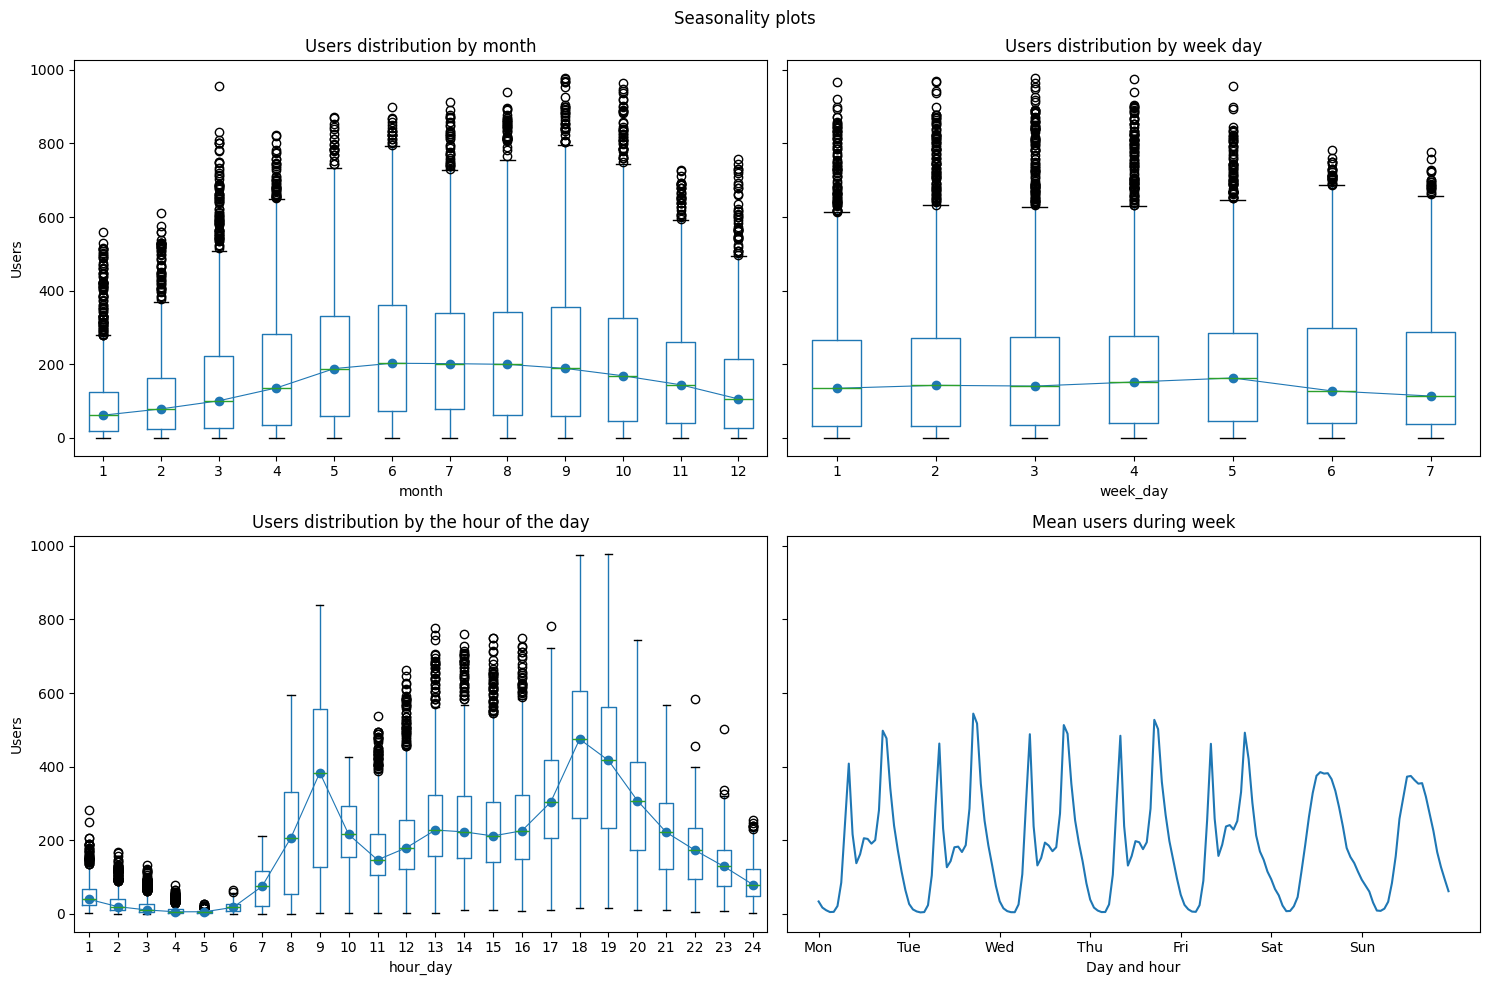

In [12]:
# Annual, weekly and daily seasonality
# ==============================================================================
fig, axs = plt.subplots(2, 2, figsize=(15, 10), sharex=False, sharey=True)
axs = axs.ravel()

# Users distribution by month
df['month'] = df.index.month
df.boxplot(column='users', by='month', ax=axs[0])
df.groupby('month')['users'].median().plot(style='o-', linewidth=0.8, ax=axs[0])
axs[0].set_ylabel('Users')
axs[0].set_title('Users distribution by month')

# Users distribution by week day
df['week_day'] = df.index.day_of_week + 1
df.boxplot(column='users', by='week_day', ax=axs[1])
df.groupby('week_day')['users'].median().plot(style='o-', linewidth=0.8, ax=axs[1])
axs[1].set_ylabel('Users')
axs[1].set_title('Users distribution by week day')

# Users distribution by the hour of the day
df['hour_day'] = df.index.hour + 1
df.boxplot(column='users', by='hour_day', ax=axs[2])
df.groupby('hour_day')['users'].median().plot(style='o-', linewidth=0.8, ax=axs[2])
axs[2].set_ylabel('Users')
axs[2].set_title('Users distribution by the hour of the day')

# Users distribution by week day and hour of the day
mean_day_hour = df.groupby(["week_day", "hour_day"])["users"].mean()
mean_day_hour.plot(ax=axs[3])
axs[3].set(
    title       = "Mean users during week",
    xticks      = [i * 24 for i in range(7)],
    xticklabels = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"],
    xlabel      = "Day and hour",
    ylabel      = "Number of users"
)

fig.suptitle("Seasonality plots")
fig.tight_layout()

- There is a clear difference between weekdays and weekends.
- Intra-day pattern: a different influx of users depending on the time of day.

### Stationarity and Differentiation

In [15]:
def check_stationarity(series, p_significant=0.05):
    # Copied from https://machinelearningmastery.com/time-series-data-stationary-python/

    adfuller_result = adfuller(series.values)
    kpss_result = kpss(series.values)

    print(f'ADF Statistic : {adfuller_result[0]:.5f}, p-value: {adfuller_result[1]:.5f}')
    print('Critical Values:')
    for key, value in adfuller_result[4].items():
        print('\t%s: %.3f' % (key, value))
    print(f'KPSS Statistic: {kpss_result[0]:.5f}, p-value: {kpss_result[1]:.5f}')
    if (adfuller_result[1] <= p_significant) & (adfuller_result[4]['5%'] > adfuller_result[0]) & (kpss_result[1] > p_significant):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

In [21]:
check_stationarity(df['users'].diff().dropna())

ADF Statistic : -29.74458, p-value: 0.00000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
KPSS Statistic: 0.01235, p-value: 0.10000
Stationary


- The original series is non-stationary, but the differenced series achived the stationary states. Hence, $d=1$

### Autocorrelation Analysis

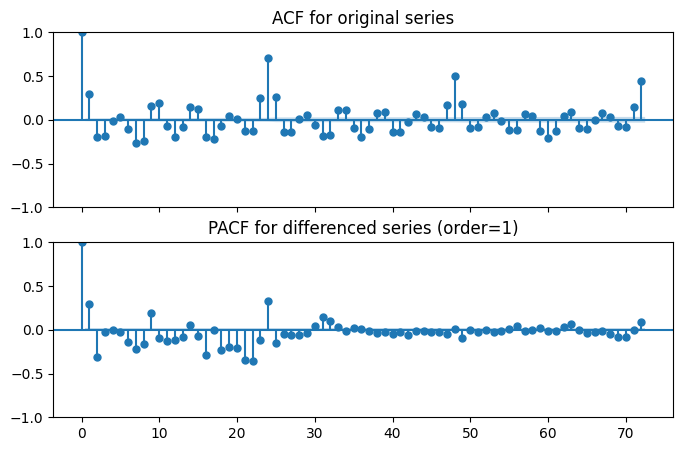

In [26]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(8, 5), sharex=True)
# we’ll only look at 72 lags = 72 hours = 3 days
df_diff_1 = df['users'].diff().dropna()
plot_acf(df_diff_1, ax=axs[0], lags=72)
axs[0].set_title('ACF for original series')

plot_pacf(df_diff_1, ax=axs[1], lags=72)
axs[1].set_title('PACF for differenced series (order=1)');

- The results of the autocorrelation study show that there is a significant correlation between the number of users in previous hours, as well as the days before

## Model Training

### Baseline Model
- Baseline model will be the one that predicts each hour using the value of the same hour on the previous day.

In [61]:
baseline_preds = pd.concat([df['users'].shift(24), df['users']], axis=1)
baseline_preds.columns = ['preds', 'ground_truth']
# baseline_preds.dropna(subset=['preds'], inplace=True)
print(f"Baseline MAE: {mean_absolute_error(baseline_preds.loc[end_validation: ,'ground_truth'], baseline_preds.loc[end_validation: ,'preds'])}")

Baseline MAE: 80.04747267759562
